Training with unknown class

In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os
import psutil
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 1. Set up device for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
# 2. Define transformations and data augmentation
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [3]:
# 3. Load datasets
data_dir = "C:/Users/bhuva/Desktop/FINAL/NEW_70_20_10"  # Define path to your dataset
batch_size = 32 
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform['val'])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform['val'])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
# 4. Define model with pretrained weights and adjust final layer
model = models.resnet50(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 101)  # Set number of classes (100 for this case)
model = model.to(device)

In [5]:
# 5. Hyperparameters and optimizer settings

num_epochs = 35
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
learning_rate = 5e-4
weight_decay = 1e-3
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    epochs=35,
    steps_per_epoch=len(train_loader)
)
early_stopping_patience = 5

In [6]:
# 6. Initialize logging for training metrics
train_log = []
best_val_loss = np.inf
patience_counter = 0

In [7]:
# 7. Training loop with progress bar and logging
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    epoch_start_time = time.time()
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    val_loss, val_acc = 0.0, 0.0

    # Validation
    model.eval()
    
    all_preds = []
    with torch.no_grad():
        correct, total = 0, 0
        val_running_loss = 0.0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            
        val_loss = val_running_loss / total
        val_acc = correct / total
    #all_probs = np.vstack(all_probs)

    scheduler.step(val_loss)

    # Document metrics
    epoch_time = time.time() - epoch_start_time
    mem_usage = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)  # Memory in MB
    train_log.append({
        'epoch': epoch + 1, 'train_loss': train_loss, 'train_acc': train_acc, 
        'val_loss': val_loss, 'val_acc': val_acc, 'epoch_time': epoch_time, 'memory_usage_mb': mem_usage
    })

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'new_bird_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_time:.2f}s")

# Save logs to CSV
pd.DataFrame(train_log).to_csv("training_with_unknown_new.csv", index=False)

Epoch 1/35: 100%|██████████| 160/160 [02:23<00:00,  1.11batch/s]
c:\Users\bhuva\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/35 - Train Loss: 3.5770, Train Acc: 0.2786, Val Loss: 2.5306, Val Acc: 0.5193, Time: 156.16s


Epoch 2/35: 100%|██████████| 160/160 [02:20<00:00,  1.14batch/s]


Epoch 2/35 - Train Loss: 2.5776, Train Acc: 0.4893, Val Loss: 1.7357, Val Acc: 0.6756, Time: 152.40s


Epoch 3/35: 100%|██████████| 160/160 [02:19<00:00,  1.14batch/s]


Epoch 3/35 - Train Loss: 2.0131, Train Acc: 0.6112, Val Loss: 1.3773, Val Acc: 0.7472, Time: 152.17s


Epoch 4/35: 100%|██████████| 160/160 [02:23<00:00,  1.11batch/s]


Epoch 4/35 - Train Loss: 1.7242, Train Acc: 0.6770, Val Loss: 1.1759, Val Acc: 0.7941, Time: 156.63s


Epoch 5/35: 100%|██████████| 160/160 [02:20<00:00,  1.14batch/s]


Epoch 5/35 - Train Loss: 1.5366, Train Acc: 0.7152, Val Loss: 1.0814, Val Acc: 0.8162, Time: 152.99s


Epoch 6/35: 100%|██████████| 160/160 [02:21<00:00,  1.13batch/s]


Epoch 6/35 - Train Loss: 1.3931, Train Acc: 0.7440, Val Loss: 1.0076, Val Acc: 0.8419, Time: 153.70s


Epoch 7/35: 100%|██████████| 160/160 [02:20<00:00,  1.14batch/s]


Epoch 7/35 - Train Loss: 1.3265, Train Acc: 0.7636, Val Loss: 0.9667, Val Acc: 0.8392, Time: 152.25s


Epoch 8/35: 100%|██████████| 160/160 [02:18<00:00,  1.15batch/s]


Epoch 8/35 - Train Loss: 1.2250, Train Acc: 0.7924, Val Loss: 0.9417, Val Acc: 0.8511, Time: 151.17s


Epoch 9/35: 100%|██████████| 160/160 [02:19<00:00,  1.15batch/s]


Epoch 9/35 - Train Loss: 1.1856, Train Acc: 0.8004, Val Loss: 0.9251, Val Acc: 0.8575, Time: 151.69s


Epoch 10/35: 100%|██████████| 160/160 [02:18<00:00,  1.15batch/s]


Epoch 10/35 - Train Loss: 1.1264, Train Acc: 0.8149, Val Loss: 0.9274, Val Acc: 0.8566, Time: 150.98s


Epoch 11/35: 100%|██████████| 160/160 [02:18<00:00,  1.15batch/s]


Epoch 11/35 - Train Loss: 1.0705, Train Acc: 0.8294, Val Loss: 0.8812, Val Acc: 0.8658, Time: 151.00s


Epoch 12/35: 100%|██████████| 160/160 [02:18<00:00,  1.15batch/s]


Epoch 12/35 - Train Loss: 1.0317, Train Acc: 0.8452, Val Loss: 0.8995, Val Acc: 0.8658, Time: 151.12s


Epoch 13/35: 100%|██████████| 160/160 [02:18<00:00,  1.16batch/s]


Epoch 13/35 - Train Loss: 1.0586, Train Acc: 0.8298, Val Loss: 0.9130, Val Acc: 0.8594, Time: 150.37s


Epoch 14/35: 100%|██████████| 160/160 [02:18<00:00,  1.16batch/s]


Epoch 14/35 - Train Loss: 1.0090, Train Acc: 0.8492, Val Loss: 0.8825, Val Acc: 0.8722, Time: 150.15s


Epoch 15/35: 100%|██████████| 160/160 [02:18<00:00,  1.15batch/s]


Epoch 15/35 - Train Loss: 0.9922, Train Acc: 0.8531, Val Loss: 0.8785, Val Acc: 0.8594, Time: 150.86s


Epoch 16/35: 100%|██████████| 160/160 [02:18<00:00,  1.15batch/s]


Epoch 16/35 - Train Loss: 0.9649, Train Acc: 0.8611, Val Loss: 0.8925, Val Acc: 0.8612, Time: 151.21s


Epoch 17/35: 100%|██████████| 160/160 [02:18<00:00,  1.16batch/s]


Epoch 17/35 - Train Loss: 0.9456, Train Acc: 0.8693, Val Loss: 0.8929, Val Acc: 0.8686, Time: 150.29s


Epoch 18/35: 100%|██████████| 160/160 [02:17<00:00,  1.16batch/s]


Epoch 18/35 - Train Loss: 0.9415, Train Acc: 0.8691, Val Loss: 0.8878, Val Acc: 0.8732, Time: 149.70s


Epoch 19/35: 100%|██████████| 160/160 [02:17<00:00,  1.16batch/s]


Epoch 19/35 - Train Loss: 0.9080, Train Acc: 0.8791, Val Loss: 0.8798, Val Acc: 0.8759, Time: 149.40s


Epoch 20/35: 100%|██████████| 160/160 [02:17<00:00,  1.16batch/s]


Early stopping triggered.


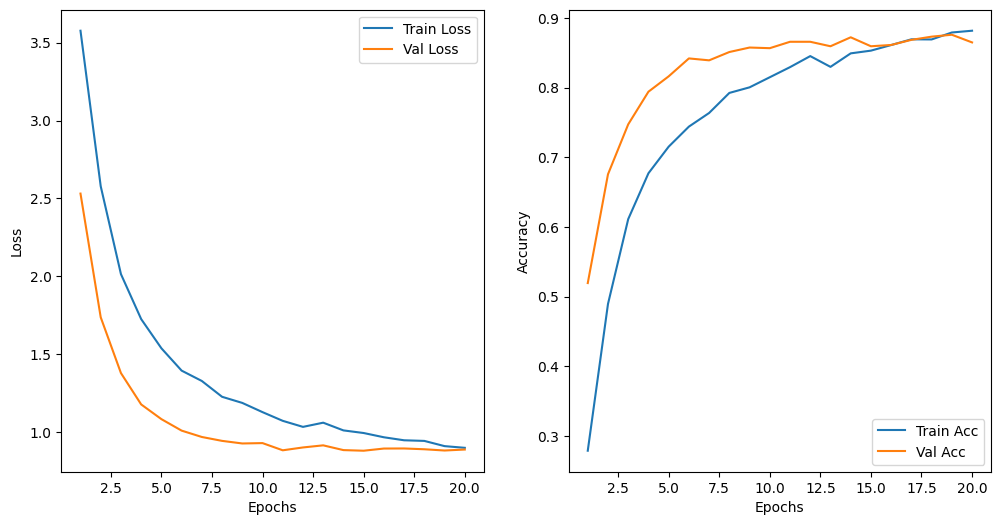

In [8]:
# 8. Plot training history
history_df = pd.DataFrame(train_log)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_df['epoch'], history_df['train_loss'], label='Train Loss')
plt.plot(history_df['epoch'], history_df['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['epoch'], history_df['train_acc'], label='Train Acc')
plt.plot(history_df['epoch'], history_df['val_acc'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
# 9. Evaluate on Test Set
model.load_state_dict(torch.load('new_bird_model.pth'))
model.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())


C:\Users\bhuva\AppData\Local\Temp\ipykernel_11212\2785647212.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('new_bird_model.pth'))


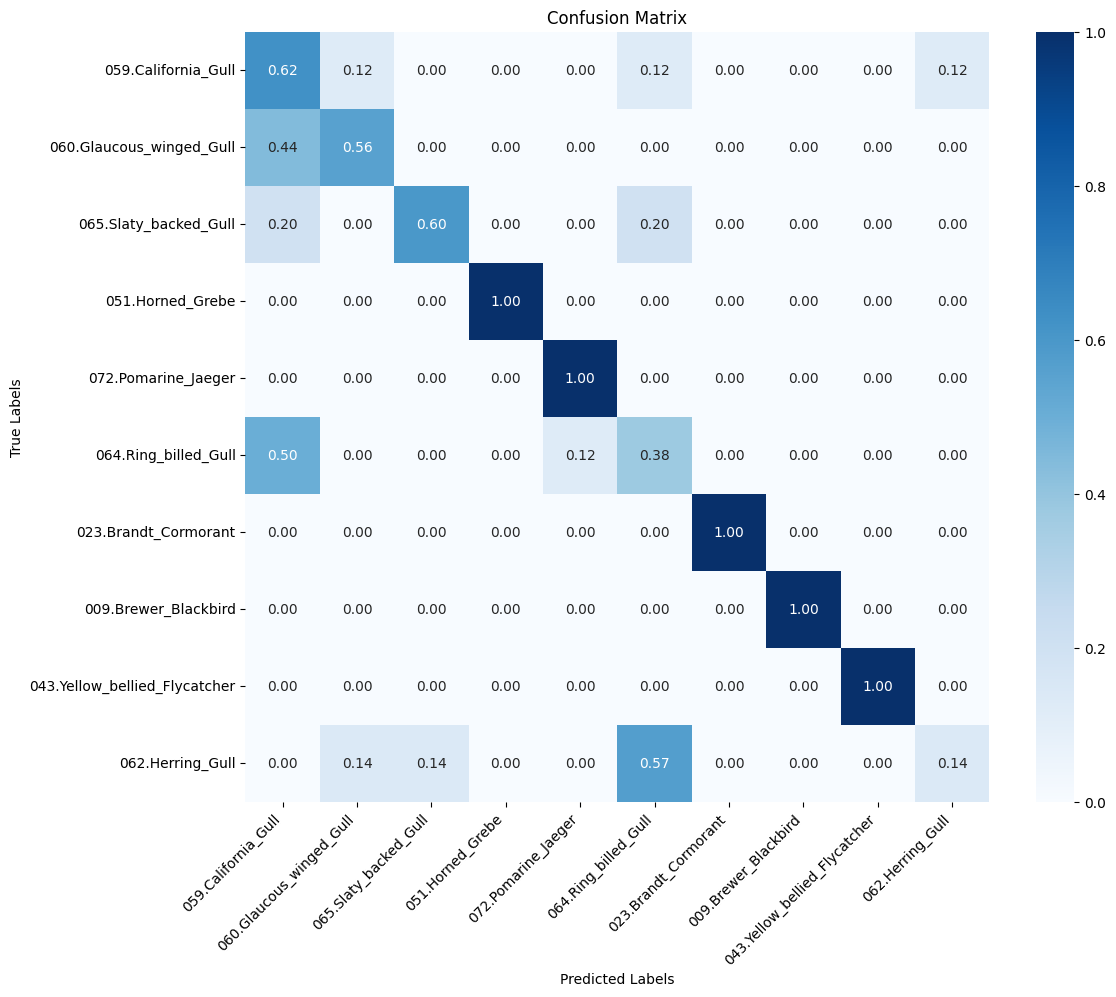

In [10]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=True, top_n=None):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Option to select top N most confused classes
    if top_n:
        # Sum across confusion matrix to find most confused classes
        misclassified_counts = np.sum(cm, axis=1) - np.diag(cm)
        # Get indices of top N most confused classes
        top_confused_indices = np.argsort(misclassified_counts)[-top_n:]
        # Select only the rows and columns of these top confused classes
        cm = cm[top_confused_indices, :][:, top_confused_indices]
        classes = [classes[i] for i in top_confused_indices]
    
    # Normalize the confusion matrix by row (i.e., by the true labels)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

class_names = ["001.Black_footed_Albatross", "002.Laysan_Albatross", "003.Sooty_Albatross", "004.Groove_billed_Ani", "005.Crested_Auklet", "006.Least_Auklet", "007.Parakeet_Auklet", "008.Rhinoceros_Auklet", "009.Brewer_Blackbird", "010.Red_winged_Blackbird", "011.Rusty_Blackbird", "012.Yellow_headed_Blackbird", "013.Bobolink", "014.Indigo_Bunting", "015.Lazuli_Bunting", "016.Painted_Bunting", "017.Cardinal", "018.Spotted_Catbird", "019.Gray_Catbird", "020.Yellow_breasted_Chat", "021.Eastern_Towhee", "022.Chuck_will_Widow", "023.Brandt_Cormorant", "024.Red_faced_Cormorant", "025.Pelagic_Cormorant", "026.Bronzed_Cowbird", "027.Shiny_Cowbird", "028.Brown_Creeper", "029.American_Crow", "030.Fish_Crow", "031.Black_billed_Cuckoo", "032.Mangrove_Cuckoo", "033.Yellow_billed_Cuckoo", "034.Gray_crowned_Rosy_Finch", "035.Purple_Finch", "036.Northern_Flicker", "037.Acadian_Flycatcher", "038.Great_Crested_Flycatcher", "039.Least_Flycatcher", "040.Olive_sided_Flycatcher", "041.Scissor_tailed_Flycatcher", "042.Vermilion_Flycatcher", "043.Yellow_bellied_Flycatcher", "044.Frigatebird", "045.Northern_Fulmar", "046.Gadwall", "047.American_Goldfinch", "048.European_Goldfinch", "049.Boat_tailed_Grackle", "050.Eared_Grebe", "051.Horned_Grebe", "052.Pied_billed_Grebe", "053.Western_Grebe", "054.Blue_Grosbeak", "055.Evening_Grosbeak", "056.Pine_Grosbeak", "057.Rose_breasted_Grosbeak", "058.Pigeon_Guillemot", "059.California_Gull", "060.Glaucous_winged_Gull", "061.Heermann_Gull", "062.Herring_Gull", "063.Ivory_Gull", "064.Ring_billed_Gull", "065.Slaty_backed_Gull", "066.Western_Gull", "067.Anna_Hummingbird", "068.Ruby_throated_Hummingbird", "069.Rufous_Hummingbird", "070.Green_Violetear", "071.Long_tailed_Jaeger", "072.Pomarine_Jaeger", "073.Blue_Jay", "074.Florida_Jay", "075.Green_Jay", "076.Dark_eyed_Junco", "077.Tropical_Kingbird", "078.Gray_Kingbird", "079.Belted_Kingfisher", "080.Green_Kingfisher", "081.Pied_Kingfisher", "082.Ringed_Kingfisher", "083.White_breasted_Kingfisher", "084.Red_legged_Kittiwake", "085.Horned_Lark", "086.Pacific_Loon", "087.Mallard", "088.Western_Meadowlark", "089.Hooded_Merganser", "090.Red_breasted_Merganser", "091.Mockingbird", "092.Nighthawk", "093.Clark_Nutcracker", "094.White_breasted_Nuthatch", "095.Baltimore_Oriole", "096.Hooded_Oriole", "097.Orchard_Oriole", "098.Scott_Oriole", "099.Ovenbird", "100.Brown_Pelican","unknown"]


# Example usage
# Assuming all_labels (true labels) and all_preds (predicted labels) are defined
# and class_names is a list of your 100 bird species names
plot_confusion_matrix(all_labels, all_preds, classes=class_names, normalize=True, top_n=10)